In [1]:
import xarray as xr
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from xgcm import Grid
import os
import zarr 
import dask
import regionmask

In [2]:
filelist = [filename for filename in os.listdir('data/SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205') if filename.startswith('ssh_grids')]
flag1 = 0
I = 0
for ssh_grids_v2205 in sorted(filelist):
    f = os.path.join("data/SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205", ssh_grids_v2205)
    ds1 = xr.open_dataset(f)
    if flag1 == 0:
        ds1.drop_vars('SLA_ERR').to_zarr('data/ssh.zarr')
        flag1 = 1
    else:
        ds1.drop_vars('SLA_ERR').to_zarr('data/ssh.zarr', append_dim = 'Time')
    print(I)
    I = I+1
    #ds = ds.merge(ds1)

ContainsGroupError: path '' contains a group

# Steps to Get U and V at 1 Time

In [21]:
ssh_1012_diffX = grid.diff(ssh_1012.SLA, axis="X")

In [22]:
ssh_1012_diffY = grid.diff(ssh_1012.SLA, axis="Y")

In [23]:
ssh_1012_difflat = grid.diff(ssh_1012.Lat_bounds, axis="Y")

In [24]:
ssh_1012_difflon = grid.diff(ssh_1012.Lon_bounds, axis="X")

$v = \frac{g}{f}\frac{\partial\eta}{\partial x}$

$u= -\frac{g}{f}\frac{\partial\eta}{\partial y}$

In [25]:
delet = ssh_1012_diffX

Delet is the difference in sea surface height between a bunch of different longitudal tiny slices

In [26]:
lamda = ssh_1012_difflon.isel(nv=1)

lamda is difference in longitude between adjacent points of longitude

In [27]:
delx = lamda*6371000*np.cos(np.radians(ssh_1012.Latitude))

In [28]:
lamday = ssh_1012_difflat.isel(nv=1)

In [29]:
dely = lamday*6371000

delx is lamda in terms of meters

In [30]:
f = 2*np.pi*np.sin(np.radians(ssh_1012.Latitude))/(3600*24)

f is the coriolis parameter, with units 1/s

In [31]:
v = (9.81*delet)/(f*delx)

In [32]:
u = -(9.81*delet)/(f*dely)

v is the velocity in the north and south direction

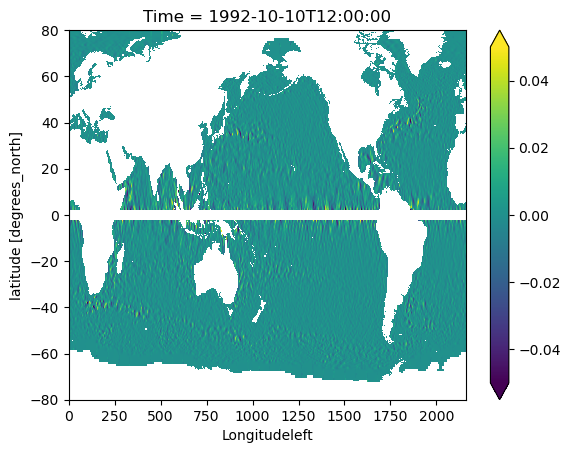

In [33]:
v.where((ssh_1012.Latitude>2)|(ssh_1012.Latitude<-2)).plot(vmin=-.05,vmax=.05)

In [3]:
from dask.distributed import LocalCluster
from dask.distributed import Client
cluster = LocalCluster()
client = Client(cluster)
client

2023-10-16 11:10:09,473 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-infk3ph1', purging
2023-10-16 11:10:09,474 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-ehfvawd3', purging
2023-10-16 11:10:09,474 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-_ouiag51', purging
2023-10-16 11:10:09,474 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-53cfntc7', purging
2023-10-16 11:10:09,474 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-swxs8_i0', purging
2023-10-16 11:10:09,475 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-kb64sqqb', purging
2023-10-16 11:10:09,475 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-uc2aqkx3', purging

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 502.57 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39829,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 502.57 GiB
Comm: tcp://127.0.0.1:37027,Total threads: 4
Dashboard: http://127.0.0.1:34507/status,Memory: 62.82 GiB
Nanny: tcp://127.0.0.1:44367,


In [2]:
ds = xr.open_zarr("data/ssh.zarr")
basins = regionmask.defined_regions.natural_earth_v5_0_0.ocean_basins_50
mask = basins.mask(ds.Longitude,ds.Latitude)

ERROR 1: PROJ: proj_create_from_database: Open of /home/jupyter-isaiah605963/.conda/envs/SSH1/share/proj failed


In [3]:
def sshv(ssh):
    ssh = ssh.assign_coords(Longitudeleft = np.arange(0,2160), Latitudeleft = np.arange(0,960))
    grid = Grid(ssh, coords={"X": {"center": "Longitude", "left": "Longitudeleft"}, 
                              "Y": {"center": "Latitude", "left": "Latitudeleft"}})
    ssh_1diffX = grid.diff(ssh.SLA, axis="X")
    ssh_1diffY = grid.diff(ssh.SLA, axis="Y")
    ssh_1difflon = grid.diff(ssh.Lon_bounds, axis="X")
    delet = ssh_1diffX
    lamda = ssh_1difflon.isel(nv=1)
    delx = np.radians(lamda)*6371000*np.cos(np.radians(ssh.Latitude))
    f = 4*np.pi*np.sin(np.radians(ssh.Latitude))/(3600*24)
    v = (9.81*delet)/(f*delx)
    iv = grid.interp(v, axis = 'X')
    return iv.where((ssh.Latitude>1)|(ssh.Latitude<-1),0)

# LEAVE THIS ALONE

In [4]:
def sshu(ssh):
    ssh = ssh.assign_coords(Longitudeleft = np.arange(0,2160), Latitudeleft = np.arange(0,960))
    grid = Grid(ssh, coords={"X": {"center": "Longitude", "left": "Longitudeleft"}, 
                              "Y": {"center": "Latitude", "left": "Latitudeleft"}})
    ssh_1diffX = grid.diff(ssh.SLA, axis="X")
    ssh_1diffY = grid.diff(ssh.SLA, axis="Y")
    ssh_1difflat = grid.diff(ssh.Lat_bounds, axis="Y")
    delet = ssh_1diffY
    theta = ssh_1difflat.isel(nv=1)
    dely = np.radians(theta)*6371000
    f = 4*np.pi*np.sin(np.radians(ssh.Latitude))/(3600*24)
    interpf = grid.interp(f, axis='Y')
    u = -(9.81*delet)/(interpf*dely)
    iu = grid.interp(u, axis = 'Y')
    return iu.where((ssh.Latitude>1)|(ssh.Latitude<-1),0)

# Beta Plane

In [5]:
def sshub(ssh):
    ssh = ssh.assign_coords(Longitudeleft = np.arange(0,2160), Latitudeleft = np.arange(0,960))
    grid = Grid(ssh, coords={"X": {"center": "Longitude", "left": "Longitudeleft"}, 
                              "Y": {"center": "Latitude", "left": "Latitudeleft"}})
    ssh_1diffX = grid.diff(ssh.SLA, axis="X")
    ssh_1diffY = grid.diff(ssh.SLA, axis="Y")
    ssh_1difflat = grid.diff(ssh.Lat_bounds, axis="Y")
    delety = ssh_1diffY
    delet = grid.interp(grid.diff(delety,axis='Y'),axis='Y')
    theta = ssh_1difflat.isel(nv=1)
    dely = np.radians(theta)*6371000
    omega = (2*(np.pi)/86400)
    beta = ((omega)*np.cos(np.radians(ssh.Latitude)))/(6371000)
    interpb = grid.interp(beta, axis='Y')
    ub = -(9.81*delet)/(interpb*dely*dely)
    iub = grid.interp(ub, axis='Y')
    return iub.where((ssh.Latitude<1)&(ssh.Latitude>-1),0)

In [6]:
def sshvb(ssh):
    ssh = ssh.assign_coords(Longitudeleft = np.arange(0,2160), Latitudeleft = np.arange(0,960))
    grid = Grid(ssh, coords={"X": {"center": "Longitude", "left": "Longitudeleft"}, 
                              "Y": {"center": "Latitude", "left": "Latitudeleft"}})
    bdelet = grid.diff(grid.diff(ssh.SLA, axis="X"), axis = 'Y')
    idelet = grid.interp(bdelet, axis='Y')
    ssh_1diffY = grid.diff(ssh.SLA, axis="Y")
    ssh_1difflon = grid.diff(ssh.Lon_bounds, axis="X")
    lamda = ssh_1difflon.isel(nv=1)
    delx = np.radians(lamda)*6371000*np.cos(np.radians(ssh.Latitude))
    ssh_1difflat = grid.diff(ssh.Lat_bounds, axis="Y")
    theta = grid.interp(ssh_1difflat.isel(nv=1), axis='Y')
    dely = np.radians(theta)*6371000
    omega = (2*(np.pi)/86400)
    beta = ((omega)*np.cos(np.radians(ssh.Latitude)))/6371000
    vb = (9.81*idelet)/(beta*delx*dely)
    ivb = grid.interp(vb,axis='X')
    return ivb.where((ssh.Latitude<1)&(ssh.Latitude>-1),0)

# Combined Beta Plane and Regular Plane

In [5]:
def sshuc(ssh):
    ssh = ssh.assign_coords(Longitudeleft = np.arange(0,2160), Latitudeleft = np.arange(0,960))
    grid = Grid(ssh, coords={"X": {"center": "Longitude", "left": "Longitudeleft"}, 
                              "Y": {"center": "Latitude", "left": "Latitudeleft"}})
    ssh_1diffX = grid.diff(ssh.SLA, axis="X")
    ssh_1diffY = grid.diff(ssh.SLA, axis="Y")
    ssh_1difflat = grid.diff(ssh.Lat_bounds.isel(nv=1), axis="Y")
    ssh_1difflat[0]=0.16667175
    delet = ssh_1diffY
    theta = ssh_1difflat
    dely = np.radians(theta)*6371000
    interplat= grid.interp(ssh.Latitude, axis='Y')
    f = 4*np.pi*np.sin(np.radians(interplat))/(3600*24)
    u = -(9.81*delet)/(f*dely)
    iu = grid.interp(u, axis = 'Y')
    deletb = grid.interp(grid.diff(delet,axis='Y'),axis='Y')
    omega = (2*(np.pi)/86400)
    beta = ((omega)*np.cos(np.radians(ssh.Latitude)))/(6371000)
    interpb = grid.interp(beta, axis='Y')
    ub = -(9.81*deletb)/(interpb*dely*dely)
    iub = grid.interp(ub, axis='Y')
    w1=((-np.abs(1/5*(ssh.Latitude)))+1).where((ssh.Latitude<5)&(ssh.Latitude>-5),0)
    w2=(np.abs(1/5*(ssh.Latitude))).where((ssh.Latitude<5)&(ssh.Latitude>-5),0)
    iunz=iu.where(np.isfinite).fillna(0)
    cub = w1*iub+w2*iunz
    ubc=w2*iunz
    iuw = iunz.where((ssh.Latitude>5)|(ssh.Latitude<-5),0)
    ccub = cub+iuw
    return ccub

In [6]:
def sshvc(ssh):
    ssh = ssh.assign_coords(Longitudeleft = np.arange(0,2160), Latitudeleft = np.arange(0,960))
    grid = Grid(ssh, coords={"X": {"center": "Longitude", "left": "Longitudeleft"}, 
                              "Y": {"center": "Latitude", "left": "Latitudeleft"}})
    ssh_1diffX = grid.diff(ssh.SLA, axis="X")
    ssh_1diffY = grid.diff(ssh.SLA, axis="Y")
    ssh_1difflon = grid.diff(ssh.Lon_bounds, axis="X")
    delet = ssh_1diffX
    lamda = ssh_1difflon.isel(nv=1)
    delx = np.radians(lamda)*6371000*np.cos(np.radians(ssh.Latitude))
    f = 4*np.pi*np.sin(np.radians(ssh.Latitude))/(3600*24)
    v = (9.81*delet)/(f*delx)
    iv = grid.interp(v, axis = 'X')
    bdelet = grid.diff(grid.diff(ssh.SLA, axis="X"), axis = 'Y')
    idelet = grid.interp(bdelet, axis='Y')
    ssh_1difflat = grid.diff(ssh.Lat_bounds, axis="Y")
    theta = grid.interp(ssh_1difflat.isel(nv=1), axis='Y')
    dely = np.radians(theta)*6371000
    omega = (2*(np.pi)/86400)
    beta = ((omega)*np.cos(np.radians(ssh.Latitude)))/6371000
    vb = (9.81*idelet)/(beta*delx*dely)
    ivb = grid.interp(vb,axis='X')
    w1=((-np.abs(1/5*(ssh.Latitude)))+1).where((ssh.Latitude<5)&(ssh.Latitude>-5),0)
    w2=(np.abs(1/5*(ssh.Latitude))).where((ssh.Latitude<5)&(ssh.Latitude>-5),0)
    cvb=w1*ivb+w2*iv
    ivw = iv.where((ssh.Latitude>5)|(ssh.Latitude<-5),0)
    ccvb = cvb+ivw
    return ccvb

# EKE found with Coriolis Parameter

In [5]:
meanu = sshu(ds).mean("Time")
meanv = sshv(ds).mean("Time")
deru = sshu(ds)- meanu
derv = sshv(ds)- meanv
dsa = ds.assign_coords(Longitudeleft = np.arange(0,2160), Latitudeleft = np.arange(0,960))
grid = Grid(dsa, coords={"X": {"center": "Longitude", "left": "Longitudeleft"}, 
                              "Y": {"center": "Latitude", "left": "Latitudeleft"}})
ssh_1difflon = dsa.Lon_bounds.isel(nv = 1)-dsa.Lon_bounds.isel(nv=0)
lamda = ssh_1difflon
delx = np.radians(lamda)*6371000*np.cos(np.radians(dsa.Latitude))
ssh_1difflat = dsa.Lat_bounds.isel(nv = 1)-dsa.Lat_bounds.isel(nv=0)
theta = ssh_1difflat
dely = np.radians(theta)*6371000
area = dely*delx

In [6]:
MKE = (1/2*1025*(meanu**2+meanv**2))
EKE = (1025*1/2*((sshu(ds)**2)+(sshv(ds)**2)))
CT = (1025*(meanu*deru+meanv*derv))
KE = MKE+CT
EKEBAR=((1/2)*1025)*(deru**2+derv**2)

/home/jupyter-isaiah605963/.conda/envs/SSH1/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


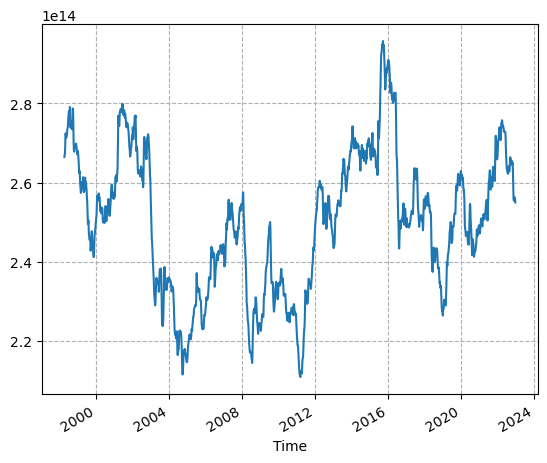

In [7]:
(EKE*area).sel(Latitude=slice(3,20),Longitude=slice(285,320)).sum(['Longitude', 'Latitude']).rolling(Time=6*12).mean().plot()
plt.grid(True, linestyle='--')


# Right Side of Area

/home/jupyter-isaiah605963/.conda/envs/SSH1/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


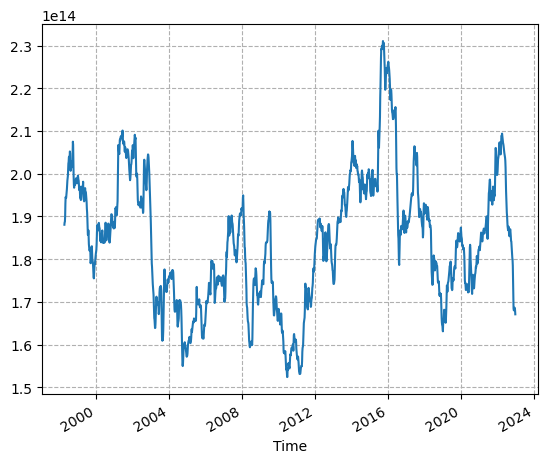

In [10]:
(EKE*area).sel(Latitude=slice(3,20),Longitude=slice(305,320)).sum(['Longitude', 'Latitude']).rolling(Time=6*12).mean().plot()
plt.grid(True, linestyle='--')

# LEFT SIDE OF AREA

/home/jupyter-isaiah605963/.conda/envs/SSH1/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jupyter-isaiah605963/.conda/envs/SSH1/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


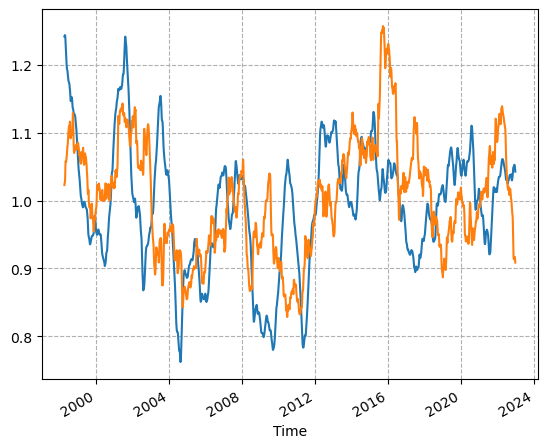

In [9]:
x = (EKE*area).sel(Latitude=slice(3,20),Longitude=slice(285,295)).sum(['Longitude', 'Latitude'])
y = (EKE*area).sel(Latitude=slice(3,20),Longitude=slice(305,320)).sum(['Longitude', 'Latitude'])
((x)/((x).mean())).rolling(Time=6*12).mean().plot()
plt.grid(True, linestyle='--')
((y)/((y).mean())).rolling(Time=6*12).mean().plot()


/home/jupyter-isaiah605963/.conda/envs/SSH1/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


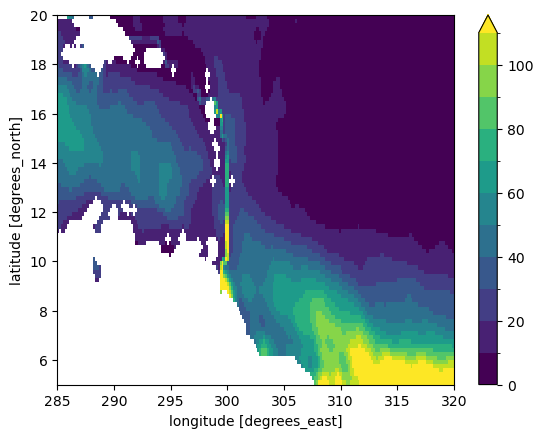

In [7]:
EKE.mean('Time').plot(xlim=(285,320),ylim=(3,20),levels=np.arange(0,120,10))

/home/jupyter-isaiah605963/.conda/envs/SSH1/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


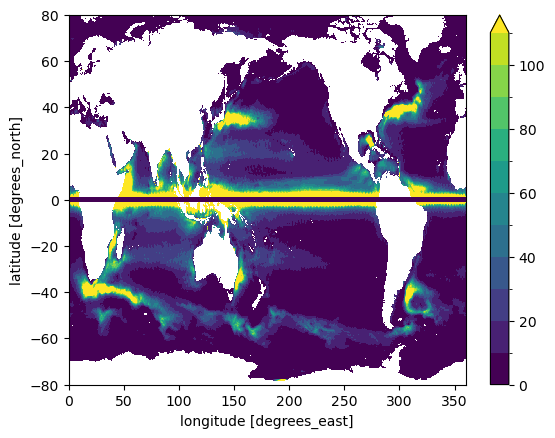

In [8]:
EKE.mean('Time').plot(levels=np.arange(0,120,10))

/home/jupyter-isaiah605963/.conda/envs/SSH1/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jupyter-isaiah605963/.conda/envs/SSH1/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


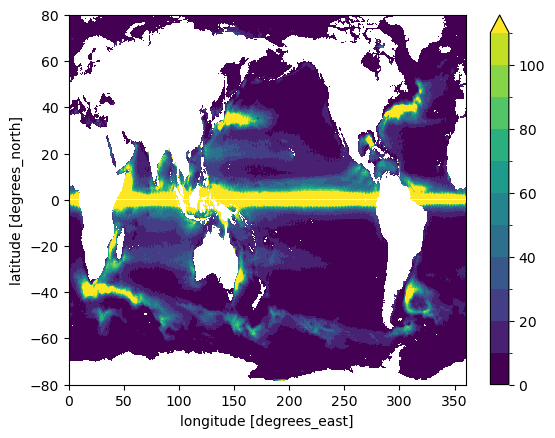

In [22]:
EKEBAR.mean("Time").plot(levels=np.arange(0,120,10))

MKE WITH ONLY CORIOLIS PARAMETER

/home/jupyter-isaiah605963/.conda/envs/SSH1/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jupyter-isaiah605963/.conda/envs/SSH1/lib/python3.9/site-packages/numpy/core/_methods.py:48: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


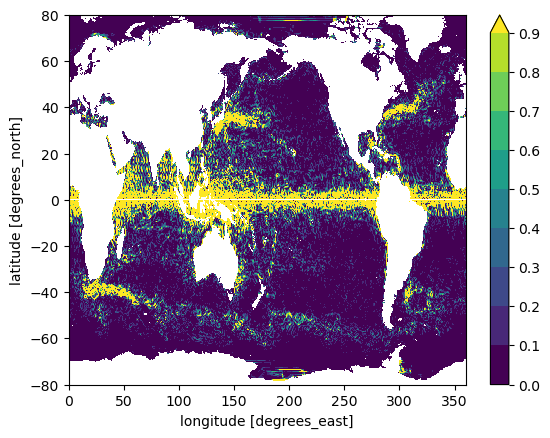

In [11]:
MKE.plot(levels = np.arange(0,1,10**-1))

# EKE found with Beta Coriolis & Regular Coriolis

In [22]:
meanuc = sshuc(ds).mean("Time")
meanvc = sshvc(ds).mean("Time")
deruc = sshuc(ds)- meanuc
dervc = sshvc(ds)- meanvc
dsa = ds.assign_coords(Longitudeleft = np.arange(0,2160), Latitudeleft = np.arange(0,960))
grid = Grid(dsa, coords={"X": {"center": "Longitude", "left": "Longitudeleft"}, 
                              "Y": {"center": "Latitude", "left": "Latitudeleft"}})
ssh_1difflon = dsa.Lon_bounds.isel(nv = 1)-dsa.Lon_bounds.isel(nv=0)
lamda = ssh_1difflon
delx = np.radians(lamda)*6371000*np.cos(np.radians(dsa.Latitude))
ssh_1difflat = dsa.Lat_bounds.isel(nv = 1)-dsa.Lat_bounds.isel(nv=0)
theta = ssh_1difflat
dely = np.radians(theta)*6371000
area = dely*delx

In [23]:
MKE = (1/2*1025*(meanuc**2+meanvc**2))
EKE = (1025*1/2*((sshuc(ds)**2)+(sshvc(ds)**2)))
CT = (1025*(meanuc*deruc+meanvc*dervc))

BETA AND REGULAR MKE PLOTED

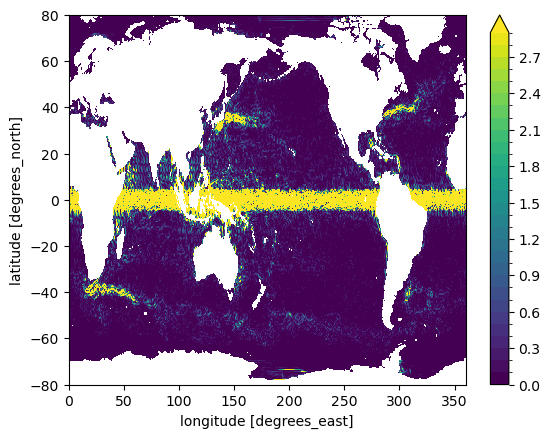

In [21]:
MKE.plot(levels = np.arange(0,3,10**-1))

/home/jupyter-isaiah605963/.conda/envs/SSH1/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


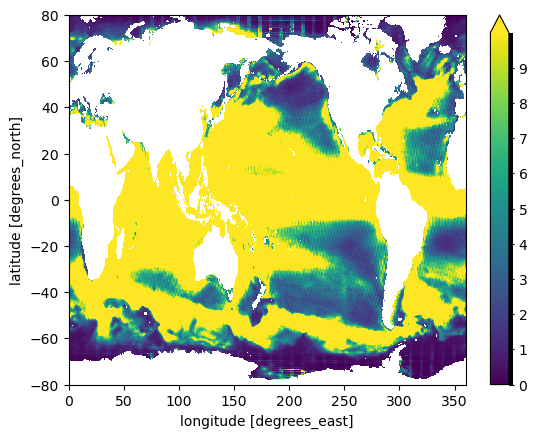

In [25]:
EKE.mean("Time").plot(levels = np.arange(0,10,10**-3))

2023-08-30 12:40:26,882 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
/home/jupyter-isaiah605963/.conda/envs/SSH1/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jupyter-isaiah605963/.conda/envs/SSH1/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jupyter-isaiah605963/.conda/envs/SSH1/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jupyter-isaiah605963/.conda/envs/SSH1/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jupyter-isaiah605963/.conda/envs/SSH1/lib/python3.9/site-packages/da

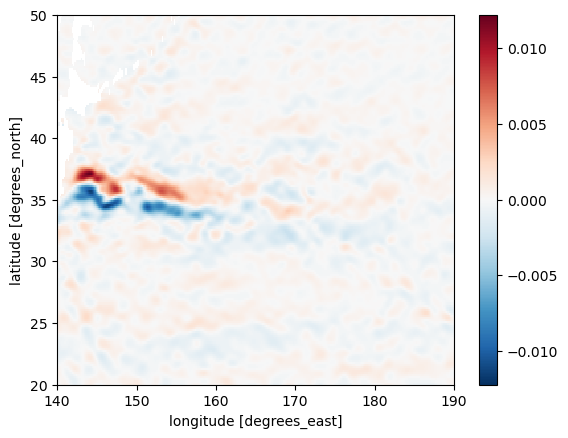

In [22]:
meanu.sel(Latitude=slice(20,50),Longitude=slice(140,190)).plot()

/home/jupyter-isaiah605963/.conda/envs/SSH1/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jupyter-isaiah605963/.conda/envs/SSH1/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jupyter-isaiah605963/.conda/envs/SSH1/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jupyter-isaiah605963/.conda/envs/SSH1/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jupyter-isaiah605963/.conda/envs/SSH1/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home

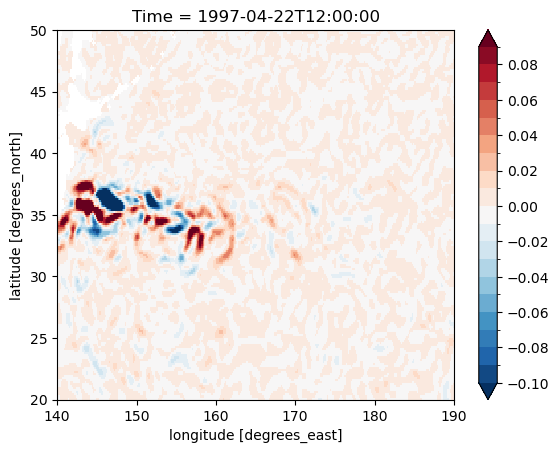

In [9]:
CT.isel(Time = 2).sel(Latitude=slice(20,50),Longitude=slice(140,190)).plot(levels = np.arange(-10**-1,10**-1,10**-2))

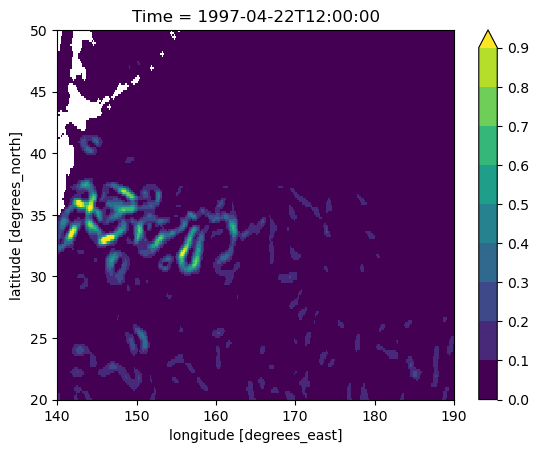

In [12]:

EKE.isel(Time=2).sel(Latitude=slice(20,50),Longitude=slice(140,190)).plot(levels = np.arange(0,1,10**-1))

In [50]:
EKE_Kuroshio = (EKE*area).sel(Latitude=slice(20,50),Longitude=slice(140,190)).sum(['Longitude', 'Latitude'])

2023-05-18 15:12:03,621 - distributed.utils_perf - WARNING - full garbage collections took 24% CPU time recently (threshold: 10%)


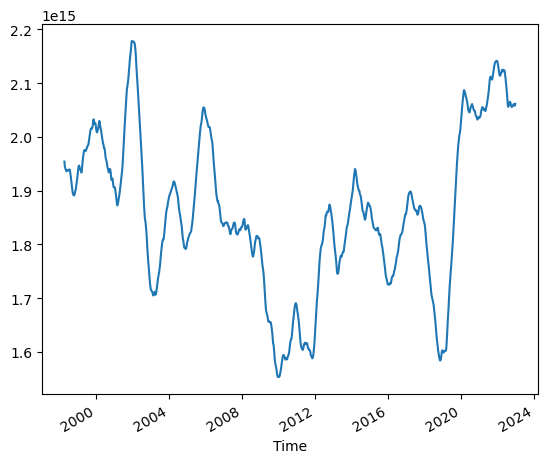

In [55]:
EKE_Kuroshio.rolling(Time=6*12).mean().plot()

/home/jupyter-isaiah605963/.conda/envs/SSH1/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jupyter-isaiah605963/.conda/envs/SSH1/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))
/home/jupyter-isaiah605963/.conda/envs/SSH1/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


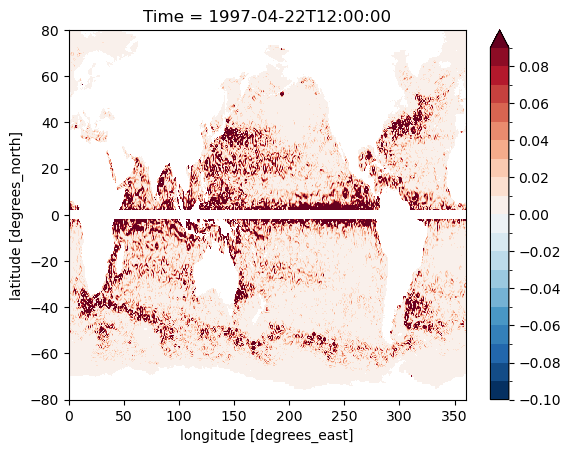

In [21]:
EKE = (1025*1/2*((sshu(ds)**2)+(sshv(ds)**2)))
EKE.isel(Time=2).plot(levels = np.arange(-10**-1,10**-1,10**-2))

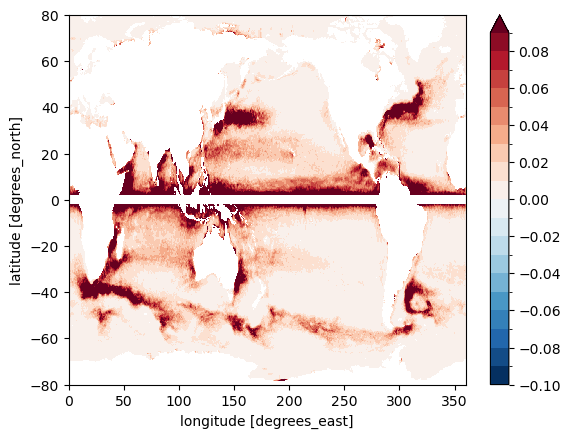

In [35]:
EKE.mean("Time").plot(levels = np.arange(-10**-1,10**-1,10**-2))

/home/jupyter-isaiah605963/.conda/envs/SSH1/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


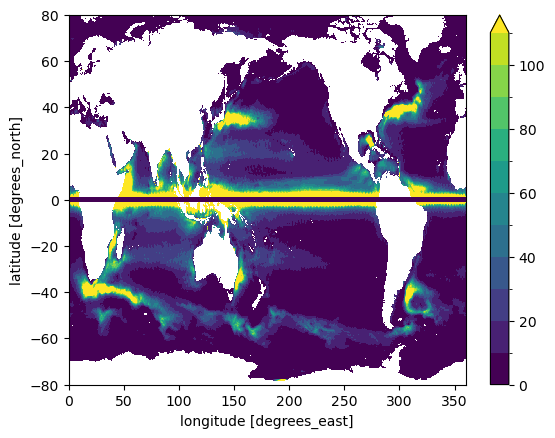

In [18]:
EKE.mean("Time").plot(levels=np.arange(0,120,10))

/home/jupyter-isaiah605963/.conda/envs/SSH1/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


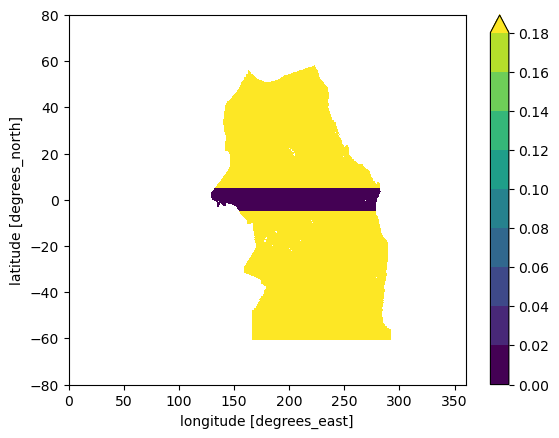

In [9]:
EKE.mean("Time").where((mask==4)|(mask==3)).plot(levels = np.arange(0,2*10**-1,2*10**-2))

In [11]:
EKEPacific = (EKE*area).where((mask==4)|(mask==3)).sum(['Longitude', 'Latitude'])

/home/jupyter-isaiah605963/.conda/envs/SSH1/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


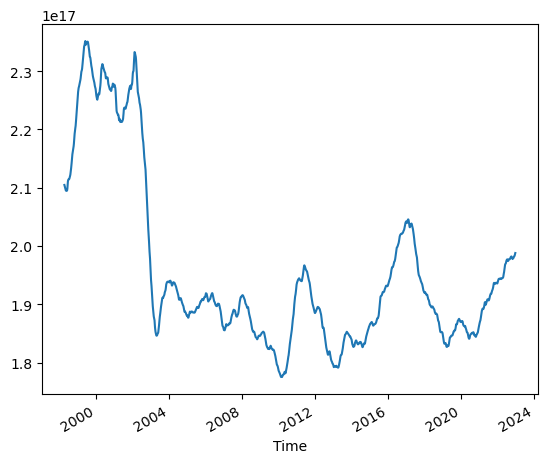

In [13]:
EKEPacific.rolling(Time=6*12).mean().plot()

In [21]:
EKESouthern = (EKE*area).where(mask==1).sum(['Longitude', 'Latitude'])

2023-08-31 09:54:44,380 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-08-31 09:54:48,226 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-08-31 09:54:56,287 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-08-31 09:55:07,999 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-08-31 09:55:15,196 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-08-31 09:55:21,903 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-08-31 09:55:28,529 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-08-31 09:55:35,515 - distributed.utils_perf - WARNING - full garbage collections took

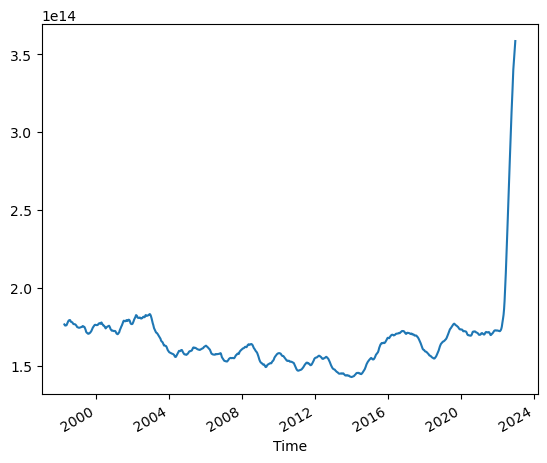

In [22]:
EKESouthern.rolling(Time=6*12).mean().plot()

In [29]:
EKEAtlantic = (EKE*area).where((mask==2)|(mask==6)).sum(['Longitude', 'Latitude'])

2023-08-31 10:02:44,926 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-08-31 10:02:49,057 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-08-31 10:02:57,489 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-08-31 10:03:09,378 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-08-31 10:03:16,733 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-08-31 10:03:23,618 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-08-31 10:03:29,470 - distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
2023-08-31 10:03:36,452 - distributed.utils_perf - WARNING - full garbage collections took

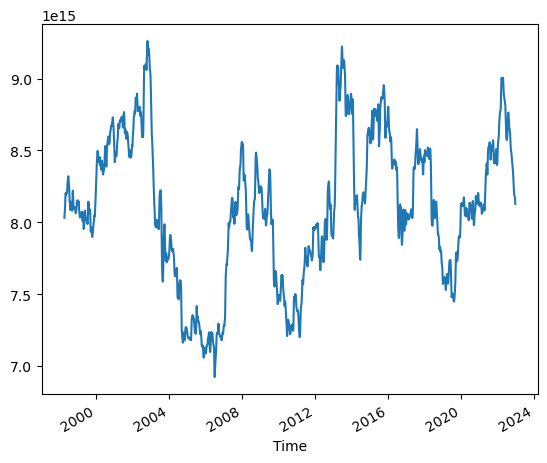

In [24]:
EKEAtlantic.rolling(Time=6*12).mean().plot()

In [28]:
EKEIndian = (EKE*area).where((mask==5)).sum(['Longitude', 'Latitude'])

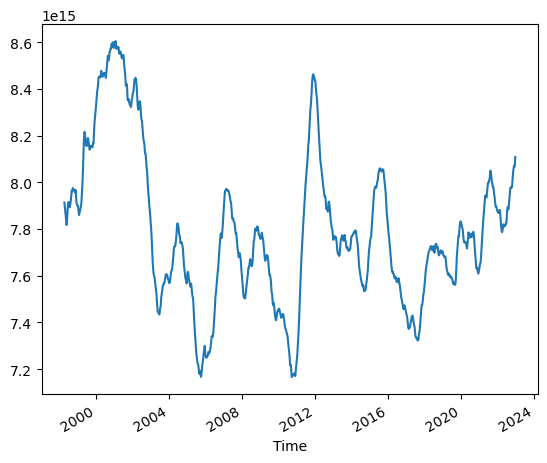

In [31]:
EKEIndian.rolling(Time=6*12).mean().plot()

In [48]:
EKEGlobal = (EKE*area).where((mask==5)|(mask==4)|(mask==3)|(mask==2)|(mask==1)|(mask==6)).sum(['Longitude', 'Latitude'])

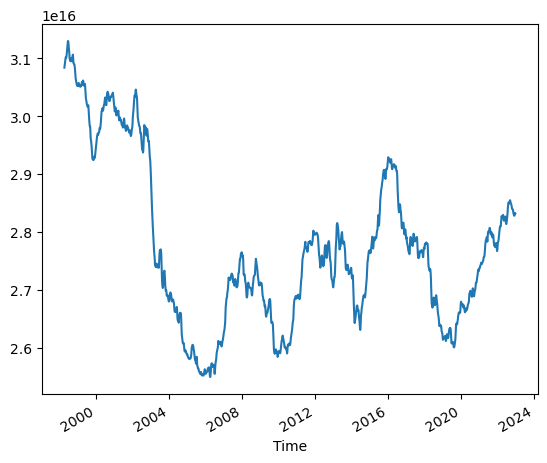

In [50]:
EKEGlobal.rolling(Time=6*12).mean().plot()